<a href="https://colab.research.google.com/github/justinchan114/satellite_image_classification/blob/main/satellite_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import re

##Load the data set (EuroSat) and see what is inside.

In [2]:
#Loading Eurosat from https://github.com/phelber/EuroSAT
all_ds = tfds.load("eurosat", with_info=True)

#check what is in all_ds
all_ds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteCXOTNB/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


({Split('train'): <_PrefetchDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>},
 tfds.core.DatasetInfo(
     name='eurosat',
     full_name='eurosat/rgb/2.0.0',
     description="""
     EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
     bands and consisting of 10 classes with 27000 labeled and
     geo-referenced samples.
     
     Two datasets are offered:
     - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
     - all: Contains all 13 bands in the original value range (float32).
     
     URL: https://github.com/phelber/eurosat
     """,
     config_description="""
     Sentinel-2 RGB channels
     """,
     homepage='https://github.com/phelber/eurosat',
     data_path='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
     file_format=tfrecord,
     download_size=8

From the description we could tell the data set contains 27000 labeled images, each with size 64x64x3. There are 10 number of classes in the feature "label".

,filename,image,label
0,Forest_687.jpg,,1 (Forest)
1,Residential_188.jpg,,7 (Residential)
2,HerbaceousVegetation_1056.jpg,,2 (HerbaceousVegetation)
3,Residential_1762.jpg,,7 (Residential)
4,Forest_943.jpg,,1 (Forest)
5,AnnualCrop_591.jpg,,0 (AnnualCrop)
6,River_1209.jpg,,8 (River)
7,AnnualCrop_425.jpg,,0 (AnnualCrop)
8,Forest_1712.jpg,,1 (Forest)
9,Residential_2145.jpg,,7 (Residential)

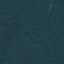
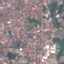
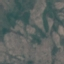
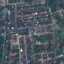
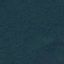
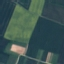
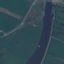
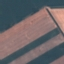
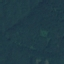
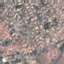

In [3]:
# Convert a subset of the training set to a Pandas dataframe, using all_ds[1] as ds_info
df = tfds.as_dataframe(all_ds[0]["train"].take(10), all_ds[1])

# Have a look on the first 10 items in the ds
df

##Train test split

In [54]:
#Split 60% for training, 20% for test, 20% for validation
train_ds = tfds.load("eurosat", split="train[:60%]")
test_ds  = tfds.load("eurosat", split="train[60%:80%]")
valid_ds = tfds.load("eurosat", split="train[80%:]")

#Get label names, which are stored in "features" (a dictionary-like object that contains information about the features of the dataset)
class_names = all_ds[1].features["label"].names
print("The classes are:", class_names)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples


The classes are: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


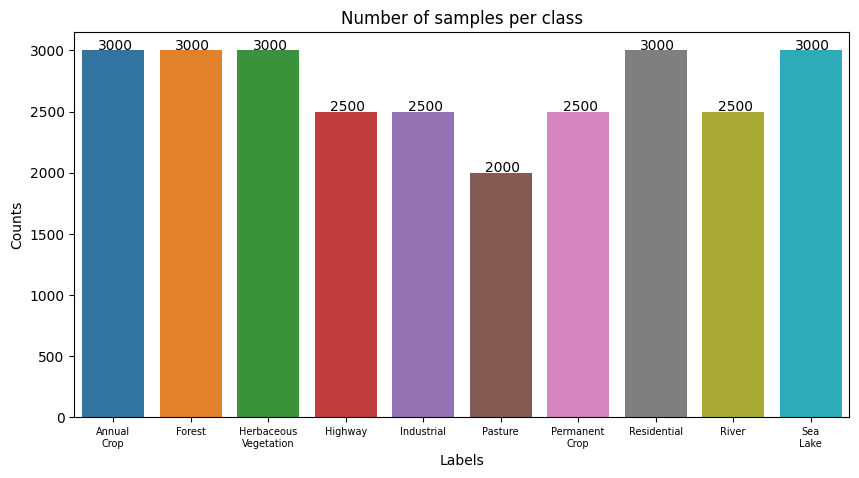

In [5]:
#all_ds[0]["train"] returns a tf.data.Dataset containing the train (e.g. {Split('train')) information of all_ds (the data).
#.map(lambda x: x["label"]) applies the lambda function to each example in the dataset, returning a new tf.data.Dataset containing only the labels.
#np.fromiter() converts the tf.data.Dataset of labels to a 1D NumPy array.
#np.unique() returns the sorted unique labels and their counts.	
labels, counts = np.unique(np.fromiter(all_ds[0]["train"].map(lambda x: x["label"]), np.int32), 	
                       return_counts=True)	

# bar plot, counting number of samples per class
fig, ax = plt.subplots(1, 1, figsize=(10,5))
	
plt.ylabel('Counts')	
plt.xlabel('Labels')	

labels_plot = [re.sub(r'([a-z])([A-Z])', r'\1\n\2', class_names[l]) for l in labels]

sns.barplot(x = labels_plot, y = counts, ax=ax) 	
for i, label in enumerate(labels_plot):	
  ax.text(i-0.2, counts[i] + 5, counts[i])
ax.set_title("Number of samples per class")	
ax.tick_params(axis='x', labelsize=7)


##Preparing data set

Now make a function to transform ds into ds for training (caching> one-hot labels> shuffle> batch> prefetch)

In [6]:
def ds_prepare(dataset, cache=True, batch_size=64, shuffle_buffer_size=1000, is_training=True):
  '''Function to set training condition of a ds'''
  if cache:
    if isinstance(cache, str):
      ds = dataset.cache(cache)
    else:
      ds = dataset.cache()
  ds = ds.map(lambda x: (x["image"], tf.one_hot(x["label"], num_classes)))
  #If the set is not for training(test set), do not shuffle
  if is_training:
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  
  return ds


Preparing the train and validation set

In [7]:
batch_size = 64

In [8]:
train_ds = ds_prepare(train_ds)
valid_ds = ds_prepare(valid_ds)

In [9]:
for item in train_ds.take(1):
  print("Image shape:", item[0].shape)
  print("One-hot label shape:", item[1].shape)

Image shape: (64, 64, 64, 3)
One-hot label shape: (64, 10)


Each batch has 64 nos. of (64,64,3) images and 10 one-hot labels.
Let's visualize the images.

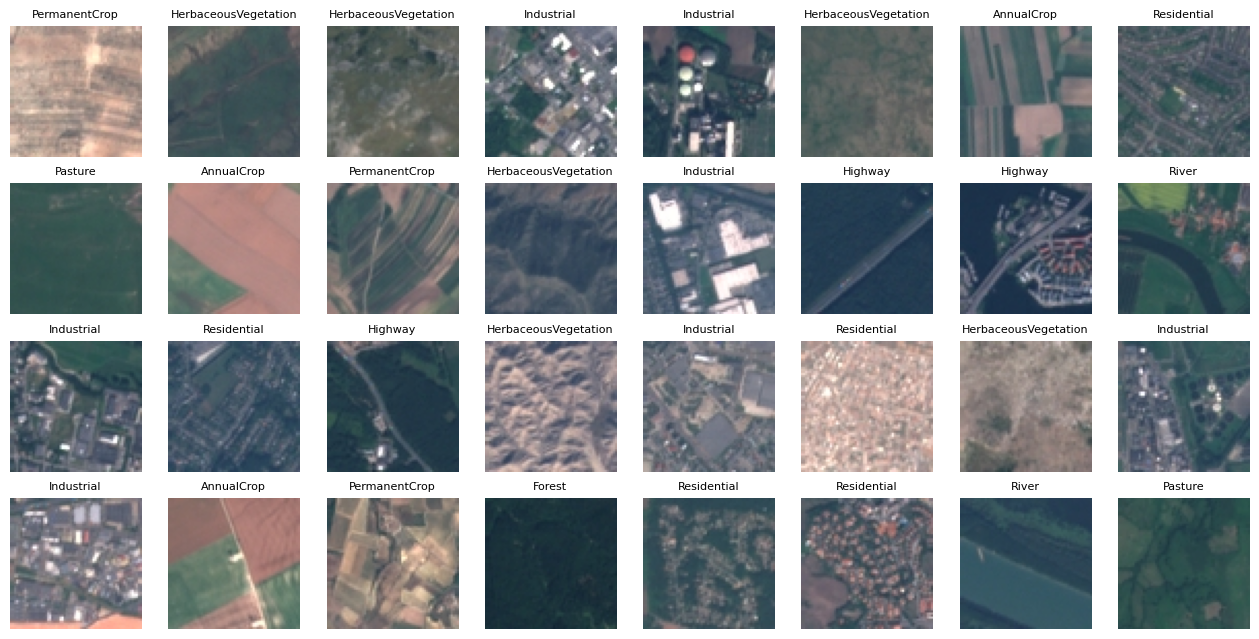

In [10]:
def show_batch(batch):
  plt.figure(figsize=(16, 16))
  for n in range(min(32, batch_size)):
      ax = plt.subplot(batch_size//8, 8, n + 1)
      plt.imshow(batch[0][n])
      class_num = tf.argmax(batch[1][n].numpy())
      plt.title(class_names[class_num],fontsize=8) # corresponding labels
      plt.axis('off')
      #plt.savefig("first_batch.png")

show_batch(next(iter(train_ds)))


##Tensor model setup and training

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
#Specifying the include_top=False argument, so that the network doesn't include the classification layers at the top
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(input_shape=(64, 64, 3),
                                               include_top=False,
                                               weights='imagenet')

24274472/24274472 [==============================] - 0s 0us/step


In [13]:
base_model.trainable = True

In [14]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  270


In [20]:
#Define data normalization with tf.keras.applications.efficientnet_v2.preprocess_input and data augmentation
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

#Use tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#Convert features into a single prediction per image,with 10 classes
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

#Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.5),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.RandomFlip("horizontal_and_vertical"),  
])

In [16]:
inputs = tf.keras.Input(shape=(64, 64, 3))

x = data_augmentation(inputs)
print(x.shape)
      
x = preprocess_input(x)
print(x.shape)

x = base_model(x, training=True)
print(x.shape)

x = global_average_layer(x)
print(x.shape)

outputs = prediction_layer(x)

print('Output has a dimension of: ' + str(outputs.shape))
model = tf.keras.Model(inputs, outputs)

(None, 64, 64, 3)
(None, 64, 64, 3)
(None, 2, 2, 1280)
(None, 1280)
Output has a dimension of: (None, 10)


In [17]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'] )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Function  (None, 2, 2, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 5,871,514
Non-train

In [18]:
model_name = "satellite_image_classifier_GAP2D"
model_path = os.path.join("output", model_name + ".h5")
epochs = 5
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)

history = model.fit(
    train_ds, 
    validation_data=valid_ds,
    verbose=1, epochs=epochs, 
    callbacks=[cp_callback]
)


Epoch 1/5
254/254 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8656
Epoch 1: val_loss improved from inf to 0.23503, saving model to output/satellite_image_classifier_GAP2D.h5
254/254 [==============================] - 464s 2s/step - loss: 0.4264 - accuracy: 0.8656 - val_loss: 0.2350 - val_accuracy: 0.9280
Epoch 2/5
254/254 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9309
Epoch 2: val_loss improved from 0.23503 to 0.14819, saving model to output/satellite_image_classifier_GAP2D.h5
254/254 [==============================] - 419s 2s/step - loss: 0.2099 - accuracy: 0.9309 - val_loss: 0.1482 - val_accuracy: 0.9522
Epoch 3/5
254/254 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9475
Epoch 3: val_loss improved from 0.14819 to 0.13945, saving model to output/satellite_image_classifier_GAP2D.h5
254/254 [==============================] - 424s 2s/step - loss: 0.1610 - accuracy: 0.9475 - val_loss: 0.1395 - val_accurac

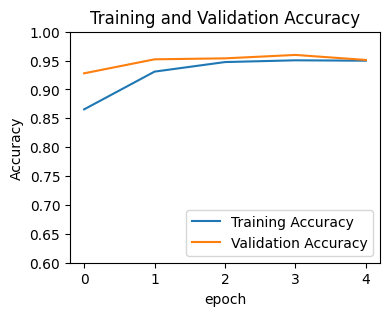

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))

# plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
ax.plot(acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.set_ylim([0.6, 1])
ax.set_title('Training and Validation Accuracy')
ax.legend(loc='lower right')
ax.set_xlabel('epoch')
ax.set_ylabel('Accuracy')
# show the plot
plt.show()


##Model Prediction on test set

In [21]:
model.load_weights('/content/output/satellite_image_classifier_GAP2D.h5')

In [55]:
#Split 60% for training, 20% for test, 20% for validation
train_ds = tfds.load("eurosat", split="train[:60%]")
test_ds  = tfds.load("eurosat", split="train[60%:80%]")
valid_ds = tfds.load("eurosat", split="train[80%:]")

In [56]:
test_ds = ds_prepare(test_ds, is_training = False)

In [57]:
X_test_ds = test_ds.map(lambda x, y: x)
y_test_ds = test_ds.map(lambda x, y: y)

In [58]:
y_pred = model.predict(X_test_ds)

85/85 [==============================] - 35s 410ms/step


In [59]:
y_pred = np.argmax(y_pred,axis = 1)
y_pred

array([9, 1, 8, ..., 3, 8, 4])

In [60]:
y_test = np.concatenate([y for y in y_test_ds])
y_test = np.argmax(y_test,axis = 1)
y_test

array([9, 1, 8, ..., 3, 8, 4])

In [61]:
test_cr = classification_report(y_test, y_pred,output_dict=True)

In [62]:
cr_df = pd.DataFrame.from_dict(test_cr).T
cr_df['class'] = class_names + ['', '', '']


In [63]:
cr_df

,precision,recall,f1-score,support,class
0,0.974093,0.943144,0.958369,598.00000,AnnualCrop
1,0.981034,0.959528,0.970162,593.00000,Forest
2,0.930421,0.941080,0.935720,611.00000,HerbaceousVegetation
3,0.923554,0.969631,0.946032,461.00000,Highway
4,0.962745,0.974206,0.968442,504.00000,Industrial
5,0.901468,0.964126,0.931744,446.00000,Pasture
6,0.944334,0.906489,0.925024,524.00000,PermanentCrop
7,0.980132,0.988314,0.984206,599.00000,Residential
8,0.970402,0.931034,0.950311,493.00000,River
9,0.973776,0.975482,0.974628,571.00000,SeaLake


The model demonstrated its ability to classify the satellite images, with accuracy of ~95%. To further improve the performance, we may further introduce cross validation or introduce few more epochs. But as the data set is not small and compulational heavy for google colab, it was not trained with cross validation.

Reference: </br>
[1] Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019. </br>
[2] Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.